In [143]:
import os
import re
from collections import defaultdict
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset_builder, load_dataset, DatasetDict, concatenate_datasets, load_from_disk, Audio
import matplotlib.pyplot as plt
from evaluate import load

from pydub import AudioSegment
import speech_recognition as sr

# Inspecting FLEURS Dataset

In [4]:
data_builder = load_dataset_builder("WueNLP/sib-fleurs", "tur_Latn")

data_builder.info.features

{'sentence': Value(dtype='string', id=None),
 'URL': Value(dtype='string', id=None),
 'id': Value(dtype='int32', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'fleurs_id': Value(dtype='int32', id=None),
 'filename': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'raw_transcription': Value(dtype='string', id=None),
 'transcription': Value(dtype='string', id=None),
 'num_samples': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'speaker_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'gender': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr_cer': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'whisper_asr_wer': Sequence(feature=Va

In [124]:
category_map = {
    0: "science/technology",
    1: "travel",
    2: "politics",
    3: "sports",
    4: "health",
    5: "entertainment",
    6: "geography"
}

language_map = {
    "tur_Latn": "tr-TR",
    "eng_Latn": "en-US",
    "spa_Latn": "es-ES",
    "fra_Latn": "fr-FR",
    "deu_Latn": "de-DE"
}

In [136]:
def remove_cols(dataset, columns_to_remove):
    try:
        return dataset.remove_columns(column_names=columns_to_remove)
    except:
        return dataset

def add_language(dataset, language):
    dataset["language"] = language
    return dataset

def proprocess_topic(dataset):
    topic = dataset["topic"]
    splitted_topic = re.split(r"/", topic)

    new_topics = []
    for element in splitted_topic:
        splitted_element = re.split(r"_", element)
        new_element = " ".join(splitted_element)
        new_topics.append(new_element.lower())
    dataset["topic"] = ", ".join(new_topics)
    return dataset 

def create_hf_ddict(train_split, validation_split, test_split):
    return DatasetDict({"train": train_split,
                        "validation": validation_split,
                        "test": test_split})

In [147]:
load_from_local = True

if load_from_local:
    proc_dataset_dict = load_from_disk("./datasets/processed/proc_dataset_dict")
else:
    # Load datasets
    fleurs_tr_ddict = load_dataset("WueNLP/sib-fleurs", "tur_Latn")
    fleurs_en_ddict = load_dataset("WueNLP/sib-fleurs", "eng_Latn")
    fleurs_sp_ddict = load_dataset("WueNLP/sib-fleurs", "spa_Latn")
    fleurs_fr_ddict = load_dataset("WueNLP/sib-fleurs", "fra_Latn")
    fleurs_du_ddict = load_dataset("WueNLP/sib-fleurs", "deu_Latn")

    fleurs_tr_ddict.save_to_disk("./datasets/raw/fleurs_tr_ddict")
    fleurs_en_ddict.save_to_disk("./datasets/raw/fleurs_en_ddict")
    fleurs_sp_ddict.save_to_disk("./datasets/raw/fleurs_sp_ddict")
    fleurs_fr_ddict.save_to_disk("./datasets/raw/fleurs_fr_ddict")
    fleurs_du_ddict.save_to_disk("./datasets/raw/fleurs_du_ddict")

    dataset_dicts = {"tur_Latn": fleurs_tr_ddict, 
                    "eng_Latn": fleurs_en_ddict, 
                    "spa_Latn": fleurs_sp_ddict, 
                    "fra_Latn": fleurs_fr_ddict, 
                    "deu_Latn": fleurs_du_ddict}
    
    columns_to_remove = ["whisper_asr","whisper_asr_cer","whisper_asr_wer","whisper_asr_translation","seamlessm4t_asr","seamlessm4t_asr_cer","seamlessm4t_asr_wer","seamlessm4t_asr_translation",
                     "index_id","speaker_id","raw_transcription","transcription","has_image","has_hyperlink","id","sentence","URL","num_samples","filename"]

    splits = {"train": [],
            "validation":[],
            "test": []}
    for split in ["train","validation","test"]:
        for language, dataset_dict in dataset_dicts.items():
            dataset_dict[split] = remove_cols(dataset_dict[split], columns_to_remove)
            dataset_dict[split] = dataset_dict[split].map(lambda x: add_language(x, language_map[language]))
            dataset_dict[split] = dataset_dict[split].map(proprocess_topic)
            
            splits[split].append(dataset_dict[split])

    train_split = concatenate_datasets(splits["train"])
    val_split = concatenate_datasets(splits["validation"])
    test_split = concatenate_datasets(splits["test"])

    proc_dataset_dict = create_hf_ddict(train_split,val_split,test_split)

    proc_dataset_dict.save_to_disk("./datasets/processed/proc_dataset_dict")

In [148]:
proc_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 3595
    })
    validation: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 343
    })
    test: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 857
    })
})

In [81]:
total_domain = defaultdict(int)
total_topic = defaultdict(int)
total_category = defaultdict(int)
total_gender = defaultdict(int)
num_audio = []
for row in reduced_fleurs_tr:
    domain = row["domain"]
    topic = row["topic"]
    category = row["category"]
    total_domain[domain] += 1
    total_topic[topic] += 1
    total_category[category] += 1
    num_audio.append(len(row["audio"]))
    for gender in row["gender"]:
        total_gender[gender] += 1

In [82]:
print(total_domain)
print(total_topic)
print(total_category)
print(total_gender)
print(num_audio)

defaultdict(<class 'int'>, {'wikibooks': 191, 'wikivoyage': 256, 'wikinews': 245})
defaultdict(<class 'int'>, {'Geography, Turkey': 4, 'World_War_II/Submarines': 3, 'Natural wonders/Hill stations in India': 2, 'travel, accomodation': 13, 'Politics': 19, 'politics': 13, 'entertainment': 13, 'Travel': 35, 'crime': 4, 'travel, archaeology': 1, 'Science/Radiography': 5, 'How_Things_Work/Nuclear_Bomb': 1, 'Internet, Communication': 3, 'Science/distance runner': 6, 'Crime and Law': 5, 'Sports': 28, 'The_Elements/Matter_Is_The_Stuff_Around_You': 5, 'South_America/The_Amazon': 2, 'Science/Sensory Systems': 3, 'Communication theory/uses and gratifications': 1, 'Science/Earth Science': 3, 'Economy and business': 2, 'sports': 28, 'travel, food': 4, 'Antartica, Travel': 9, 'how things work, lightbulb': 2, 'Science/First Aid': 3, 'Reason to travel/Funeral travel': 3, 'Disease': 3, 'video/dvd': 4, 'Science': 12, 'Culture and entertainment': 6, 'International': 2, 'travel': 43, 'how things work, ice 

In [83]:
total_topic.keys()

dict_keys(['Geography, Turkey', 'World_War_II/Submarines', 'Natural wonders/Hill stations in India', 'travel, accomodation', 'Politics', 'politics', 'entertainment', 'Travel', 'crime', 'travel, archaeology', 'Science/Radiography', 'How_Things_Work/Nuclear_Bomb', 'Internet, Communication', 'Science/distance runner', 'Crime and Law', 'Sports', 'The_Elements/Matter_Is_The_Stuff_Around_You', 'South_America/The_Amazon', 'Science/Sensory Systems', 'Communication theory/uses and gratifications', 'Science/Earth Science', 'Economy and business', 'sports', 'travel, food', 'Antartica, Travel', 'how things work, lightbulb', 'Science/First Aid', 'Reason to travel/Funeral travel', 'Disease', 'video/dvd', 'Science', 'Culture and entertainment', 'International', 'travel', 'how things work, ice skates', 'American education/technology (Social media)', 'sport', 'sailing', 'Managing Groups & Teams/Motivation', 'Cognitive Psycology and Neuroscience/MRI', 'Transport/History', 'health', 'Cognitive Psycology 

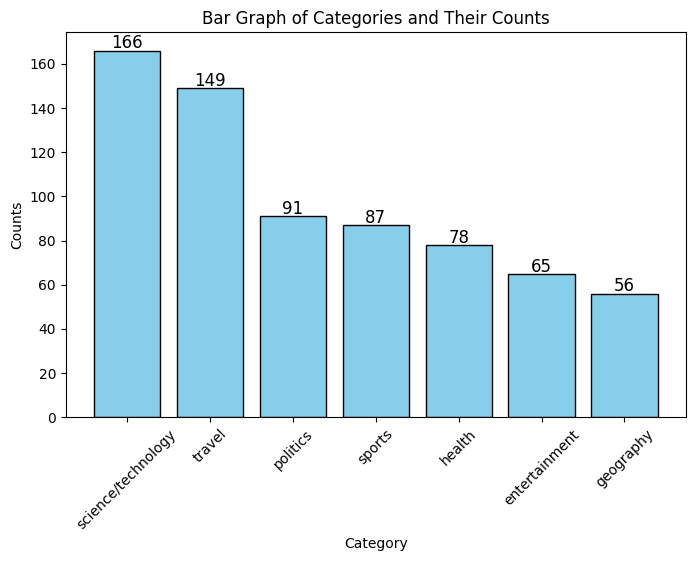

In [ ]:
sorted_data = dict(sorted(total_category.items(), key=lambda item: item[1], reverse=True))

# Extract categories and counts
categories = list(sorted_data.keys())
counts = list(sorted_data.values())

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar([category_map[category] for category in categories], counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Counts")
plt.title("Bar Graph of Categories and Their Counts")

plt.xticks(rotation=45)

# Show values on top of bars
for i, count in enumerate(counts):
    plt.text(category_map[categories[i]], count+1, str(count), ha='center', fontsize=12)

# Display the graph
plt.show()

# Speech Recognition

In [67]:
# Convert NumPy array to bytes
audio_array = fleurs_tr[0]["audio"][0]["array"]
fixed_audio_array = (audio_array * 2147483647).astype(np.int32)  # Scale for int32
audio_bytes = fixed_audio_array.tobytes()

# Create an AudioSegment
audio_segment = AudioSegment(
    data=audio_bytes,
    sample_width=4,
    frame_rate=fleurs_tr[0]["audio"][0]["sampling_rate"],
    channels=1)

In [68]:
# Save as a temporary WAV file (needed for speech recognition)
temp_wav = "temp_audio.wav"
audio_segment.export(temp_wav, format="wav")

# Initialize speech recognizer
recognizer = sr.Recognizer()
# Load the temporary WAV file
with sr.AudioFile(temp_wav) as source:
    audio_data = recognizer.record(source)  # Capture the entire audio

# Perform speech recognition
try:
    text = recognizer.recognize_google(audio_data,  language="tr-TR")
    print("Recognized Speech:", text)
except sr.UnknownValueError:
    print("Speech recognition could not understand the audio")
except sr.RequestError:
    print("Could not request results from Google Speech Recognition")

Recognized Speech: Türkiye'nin Üç tarafı denizlerle çevrilidir batıda Ege Denizi kuzeyde Karadeniz ve güneyde Akdeniz
